In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, feature, transform
from skimage.color import rgb2gray
from skimage.transform import radon, iradon
import cv2

In [2]:

def apply_radon_transform(image, angles=None):
    """
    Apply Radon transform to detect lines and patterns in an image.
    
    Parameters:
    - image: 2D numpy array (grayscale image)
    - angles: array of angles for projection (default: 0 to 180 degrees)
    
    Returns:
    - sinogram: Radon transform result
    - angles: angles used for transform
    """
    if angles is None:
        angles = np.linspace(0., 180., max(image.shape), endpoint=False)
    
    # Apply Radon transform
    sinogram = radon(image, theta=angles, circle=True)
    
    return sinogram, angles


In [3]:

def apply_hough_transform(image, threshold=50):
    """
    Apply Hough Line Transform to detect straight lines in an image.
    
    Parameters:
    - image: 2D numpy array (grayscale image)
    - threshold: minimum number of intersections to detect a line
    
    Returns:
    - lines: detected lines in (rho, theta) format
    - edges: edge-detected image used for Hough transform
    """
    # Apply edge detection (Canny)
    edges = feature.canny(image, sigma=2, low_threshold=0.1, high_threshold=0.2)
    
    # Apply Hough Line Transform
    tested_angles = np.linspace(-np.pi/2, np.pi/2, 360, endpoint=False)
    hough_lines = transform.hough_line(edges, theta=tested_angles)
    hough_space, angles, dists = hough_lines
    
    # Find peaks (lines)
    hough_peaks = transform.hough_line_peaks(hough_space, angles, dists, 
                                           threshold=threshold, num_peaks=10)
    
    return hough_peaks, edges, hough_space


In [4]:

def plot_results(original_image, sinogram, angles, hough_peaks, edges, hough_space):
    """
    Plot original image, Radon transform results, and Hough transform results.
    """
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original image
    axes[0, 0].imshow(original_image, cmap='gray')
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # Radon transform (sinogram)
    axes[0, 1].imshow(sinogram, cmap='hot', aspect='auto',
                     extent=[angles[0], angles[-1], 0, sinogram.shape[0]])
    axes[0, 1].set_title('Radon Transform (Sinogram)')
    axes[0, 1].set_xlabel('Projection Angle (degrees)')
    axes[0, 1].set_ylabel('Projection Position')
    
    # Reconstructed image from Radon transform
    reconstruction = iradon(sinogram, theta=angles, circle=True)
    axes[0, 2].imshow(reconstruction, cmap='gray')
    axes[0, 2].set_title('Radon Reconstruction')
    axes[0, 2].axis('off')
    
    # Edge detection result
    axes[1, 0].imshow(edges, cmap='gray')
    axes[1, 0].set_title('Edge Detection (Canny)')
    axes[1, 0].axis('off')
    
    # Hough space
    angles_deg = np.rad2deg(hough_peaks[1])
    dists = hough_peaks[2]
    
    axes[1, 1].imshow(hough_space, cmap='hot', origin='lower')
    axes[1, 1].set_title('Hough Transform Space')
    axes[1, 1].set_xlabel('Angles')
    axes[1, 1].set_ylabel('Distance')
    
    # Original image with detected lines
    axes[1, 2].imshow(original_image, cmap='gray')
    
    # Draw detected lines
    for angle, dist in zip(hough_peaks[1], hough_peaks[2]):
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - original_image.shape[1] * np.cos(angle)) / np.sin(angle)
        axes[1, 2].plot([0, original_image.shape[1]], [y0, y1], '-r', linewidth=2)
    
    axes[1, 2].set_xlim([0, original_image.shape[1]])
    axes[1, 2].set_ylim([original_image.shape[0], 0])
    axes[1, 2].set_title('Detected Lines (Hough)')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()


In [5]:

def main():
    """
    Main function demonstrating Radon and Hough transforms
    """

    image = cv2.imread('processed_image.jpg', cv2.IMREAD_GRAYSCALE)

    
    print("Image shape:", image.shape)
    print("Applying transforms...")
    
    # Apply Radon Transform
    angles = np.linspace(0., 180., max(image.shape), endpoint=False)
    sinogram, angles = apply_radon_transform(image, angles)
    
    # Apply Hough Transform
    hough_peaks, edges, hough_space = apply_hough_transform(image, threshold=100)
    
    print(f"Detected {len(hough_peaks[0])} lines with Hough transform")
    
    # Plot results
    plot_results(image, sinogram, angles, hough_peaks, edges, hough_space)
    
    # Print some statistics
    print("\nRadon Transform Statistics:")
    print(f"Sinogram shape: {sinogram.shape}")
    print(f"Projection angles: {len(angles)} angles from {angles[0]:.1f}° to {angles[-1]:.1f}°")
    
    print("\nHough Transform Statistics:")
    print(f"Number of detected lines: {len(hough_peaks[0])}")
    if len(hough_peaks[0]) > 0:
        print(f"Line angles (degrees): {np.rad2deg(hough_peaks[1])}")
        print(f"Line distances: {hough_peaks[2]}")


Image shape: (2323, 2500)
Applying transforms...


c:\Users\Utente\Desktop\Vision\prog\.conda\Lib\site-packages\skimage\transform\radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


Detected 10 lines with Hough transform


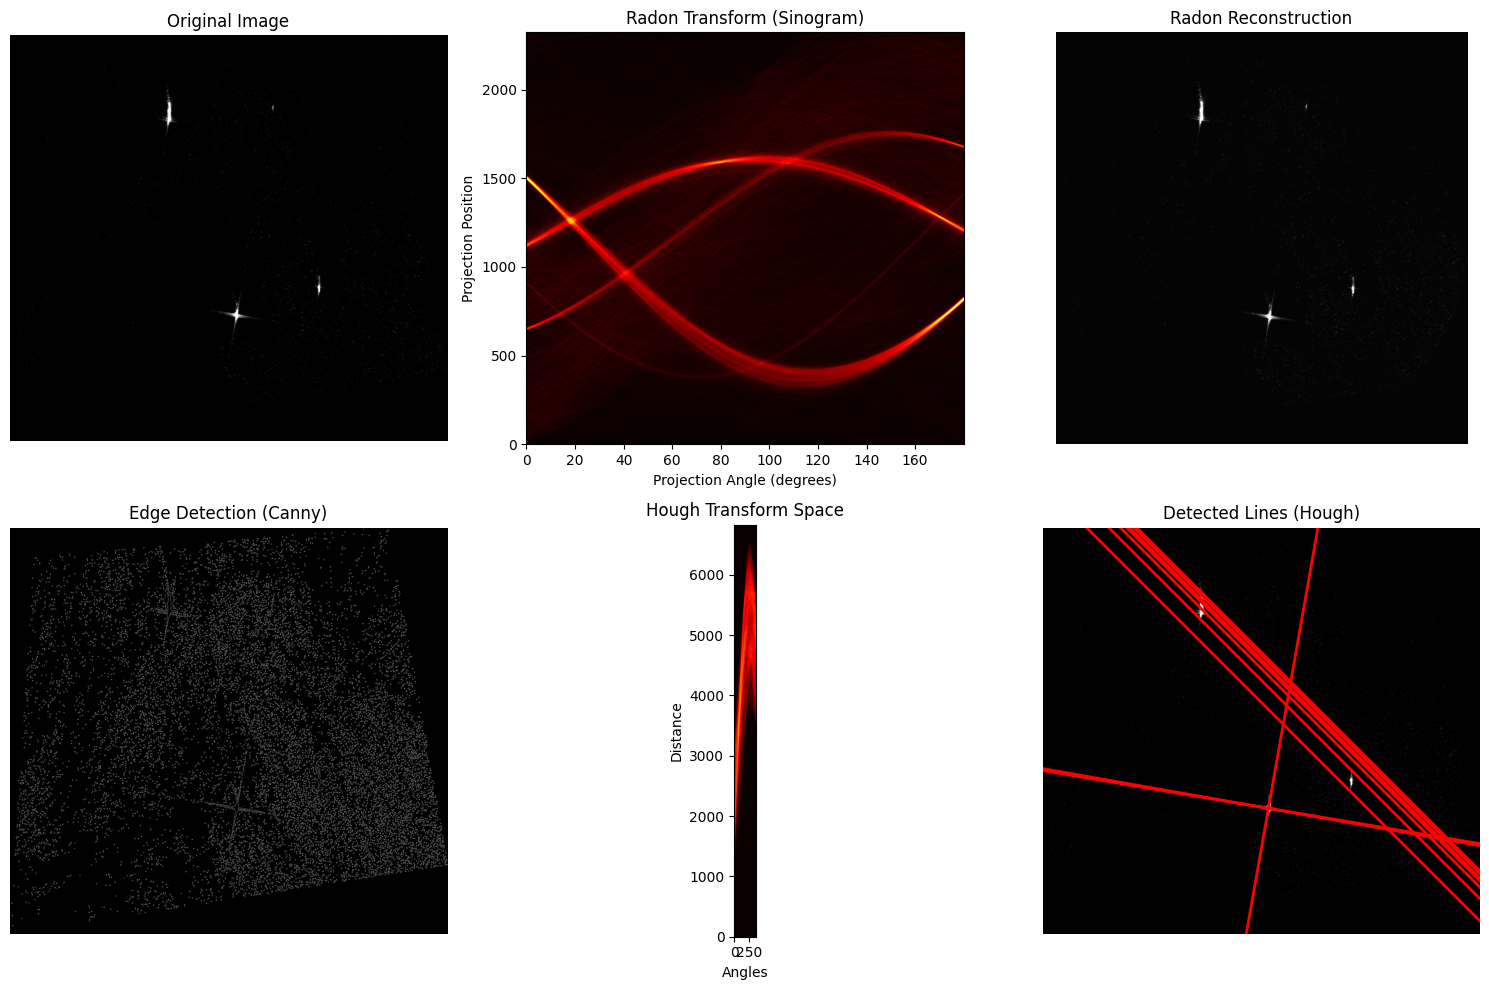


Radon Transform Statistics:
Sinogram shape: (2323, 2500)
Projection angles: 2500 angles from 0.0° to 179.9°

Hough Transform Statistics:
Number of detected lines: 10
Line angles (degrees): [-45.  -45.  -80.  -45.  -45.  -45.   10.  -80.5 -45.  -45. ]
Line distances: [  313.   380. -1357.   351.   368.   339.  1549. -1370.   177.   267.]


In [6]:
if __name__ == "__main__":
    # Install required packages:
    # pip install scikit-image matplotlib opencv-python numpy
    
    main()